# Setup

Download the necessary files:
- [MEPS 2019](https://www.meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-216)
- [Medical inflation](https://fred.stlouisfed.org/series/CPIMEDSL)
- [Overall inflation](https://fred.stlouisfed.org/series/CPIAUCSL)
- [marketplace premium rates by age](https://www.cms.gov/CCIIO/Resources/Data-Resources/marketplace-puf)

Only run code cells in this section if you need to download the input data.  Data files will be saved to ./data

In [357]:
%%bash
    mkdir data

mkdir: cannot create directory ‘data’: File exists


In [232]:
import requests

def download_file(http, save_as):
    response = requests.get(http)
    with open("data/"+save_as, "wb") as f:
        f.write(response.content)
        
meps = {"http": "https://meps.ahrq.gov/data_files/pufs/h216/h216dta.zip"
       , "save_as": "h216dta.zip"
       }
fred_medcpi = {"http": "https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1169&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=CPIMEDSL&scale=left&cosd=1947-01-01&coed=2022-12-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Monthly&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2023-01-12&revision_date=2023-01-12&nd=1947-01-01"
       , "save_as": "CPIMEDSL.csv"
       }
fred_cpi = {"http":"https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1169&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=CPIAUCSL&scale=left&cosd=1947-01-01&coed=2022-12-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Monthly&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2023-01-13&revision_date=2023-01-13&nd=1947-01-01"
           , "save_as": "CPIAUCSL.csv"
           }
cms_rates = {"http": "https://download.cms.gov/marketplace-puf/2023/rate-puf.zip"
            , "save_as": "rate-puf.zip"
            }
mortality = {"http": "https://ftp.cdc.gov/pub/Health_Statistics/NCHS/Datasets/DVS/mortality/mort2019us.zip"
            , "save_as":"mort2019us.zip"
            }

# download_list = [meps, fred_medcpi, fred_cpi, cms_rates, mortality]
download_list = [fred_wps]

# download each specified above
for d in download_list:
    download_file(d["http"], d["save_as"])

Unzip:
- h216dta.zip
- mort2019us.zip
- rate-puf.zip

In [27]:
%%bash
    cd data
    unzip h216dta.zip
    unzip mort2019us.zip
    unzip rate-puf.zip
    mv h216.dta full2019_expenses.dta

# Inflation Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
medcpi = pd.read_csv("data/CPIMEDSL.csv", index_col="DATE")
cpi = pd.read_csv("data/CPIAUCSL.csv", index_col="DATE")

In [3]:
inflation = medcpi.merge(cpi, on="DATE", how='left')

In [4]:
# cost increase from 2019 to 2023
cost_factor = inflation['CPIMEDSL'].loc['2022-12-01'] / inflation['CPIMEDSL'].loc['2019-12-01']

In [5]:
cost_factor

1.0810884348415033

# MEPS expense by age

In [6]:
# run separate script to clean MEPS data to something usable
import prepare_base_data_file
prepare_base_data_file.main()

In [6]:
meps = pd.read_csv("data/base_meps_data.csv")

In [7]:
# only ages eligible for FFM insurance
mask = np.logical_and(meps['age'] >= 23, meps['age'] <= 62)
meps = meps[mask]

In [8]:
# keep only rows where self and private add up to total
meps['tot_exp_calc'] = meps['tot_exp_private'] + meps['tot_exp_self']
meps['calc_ratio'] = np.abs(meps['tot_exp_calc'] / meps['tot_exp'] - 1)
meps['calc_delta'] = np.abs(meps['tot_exp_calc'] - meps['tot_exp'])

mask = np.logical_or(
    meps['calc_ratio'] < .01
    , meps['calc_delta'] < 50
)

meps = meps.loc[mask]

print(f'excluding {np.sum(~mask)} rows with non self or private ins payments : {np.mean(~mask)*100:0.2f}%')

excluding 1380 rows with non self or private ins payments : 14.46%


In [9]:
len(meps)

8161

In [10]:
# get expenditure without dental or vision
# and scale up to 2023 dollars
for tag in ['', '_private', '_self']:
    if tag == '':
        tag2 = '_exp'
    else:
        tag2 = tag
    meps[f'med_exp{tag}'] = (meps[f'tot_exp{tag}'] - meps[f'tot_dental{tag2}'] - meps[f'tot_vision{tag2}'])
    meps[f'med_exp{tag}'] *= cost_factor

In [11]:
# meps['age_bucket'] = np.floor(meps['age']//10)*10+5
meps['age_bucket'] = ((meps['age']+2)//5)*5
meps['age_bucket2'] = np.round(np.floor(meps['age']//10)*10+5)
meps['is_spend_low'] = meps['med_exp'] < 1000
meps['is_spend_medium'] = np.logical_and(meps['med_exp'] >= 1000, meps['med_exp'] <= 10000)
meps['is_spend_high'] = meps['med_exp'] > 10000

meps['spend_bkt'] = "low"
meps.loc[meps['is_spend_medium'],'spend_bkt'] = "medium"
meps.loc[meps['is_spend_high'],'spend_bkt'] = "high"

In [12]:
meps_agg = meps.groupby(by=['age_bucket'], as_index=False).agg(
    mean = pd.NamedAgg('med_exp', np.mean)
    , p50 = pd.NamedAgg('med_exp', np.median)
    , n = pd.NamedAgg('dupersid', 'count')
    , n_low = pd.NamedAgg('is_spend_low', 'sum')
    , n_medium = pd.NamedAgg('is_spend_medium', 'sum')
    , n_high = pd.NamedAgg('is_spend_high', 'sum')
    , mean_private = pd.NamedAgg('med_exp_private', np.mean)
    , mean_self = pd.NamedAgg('med_exp_self', np.mean)
)

In [13]:
for tag in ["low", "medium", "high"]:
    meps_agg[f'pct_{tag}'] = meps_agg[f'n_{tag}'] / meps_agg['n']

In [14]:
for tag in ['private','self']:
    meps_agg[f'pct_{tag}'] = meps_agg[f'mean_{tag}'] / meps_agg['mean']

<AxesSubplot: xlabel='age_bucket', ylabel='med_exp'>

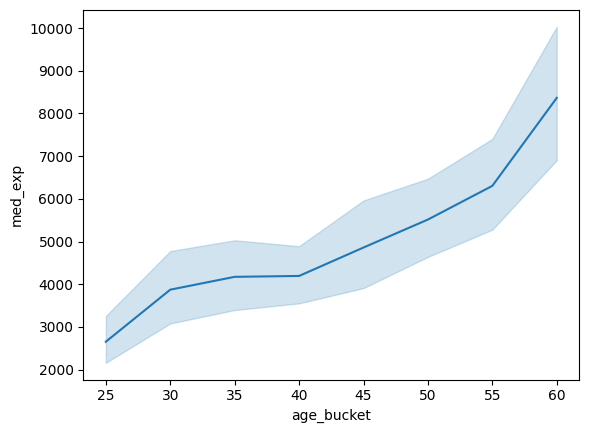

In [15]:
# plot expenditure by age and sex
import seaborn as sns
sns.lineplot(data=meps, x = 'age_bucket', y = 'med_exp')

[(500.0, 1500.0)]

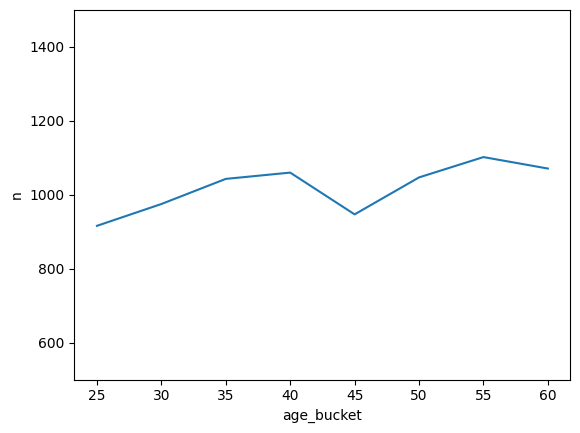

In [16]:
g = sns.lineplot(data=meps_agg, x="age_bucket", y="n")
g.set(ylim=(500,1500))

# Process Premium Data

In [17]:
keep_cols = ['RateEffectiveDate', 'RateExpirationDate', 'StateCode', 'RatingAreaId', 'PlanId', 'Age', 'IndividualRate', ]

In [18]:
rates = pd.read_csv("data/Rate_PUF.csv", usecols=keep_cols, index_col='PlanId')

In [19]:
rates.columns = rates.columns.str.lower()

In [20]:
excl_vals = {
    'age': ['Family Option', '0-14', '64 and over']
    , 'rateeffectivedate': ['2023-10-01', '2023-04-01', '2023-07-01']
    , 'rateexpirationdate': ['2023-03-31', '2023-06-30', '2023-09-30']
}

In [21]:
incl_vals = {
    'statecode': ['TX','FL','IL','OH','GA','NC']  # together are 50% of pop of FFM states
}

In [22]:
for col, var_vals in excl_vals.items():
    rates = rates.loc[~rates[col].isin(var_vals)]
    
for col, var_vals in incl_vals.items():
    rates = rates.loc[rates[col].isin(var_vals)]

In [23]:
rates = rates.astype({'age':'int'})

In [24]:
mask = np.logical_and(rates.age >= 23, rates.age <= 62)
rates = rates.loc[mask]

In [25]:
rates_agg = rates.groupby(by="age", as_index=False).agg(
    p50 = pd.NamedAgg("individualrate", np.median)
    , count = pd.NamedAgg("age", "count")
)
rates_agg['p50_annual'] = rates_agg.p50*12

<AxesSubplot: xlabel='age', ylabel='p50_annual'>

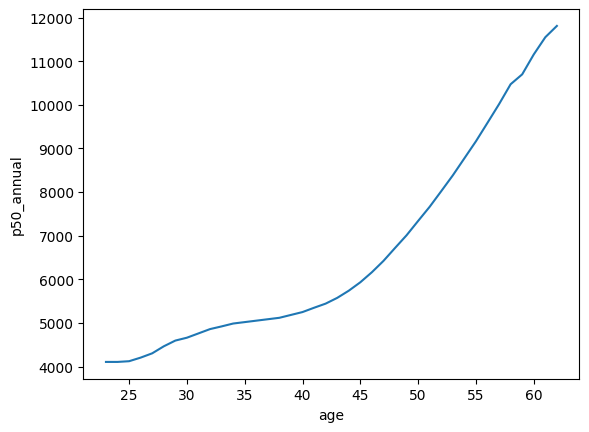

In [26]:
sns.lineplot(data=rates_agg, x="age", y="p50_annual")

# KEY PLOTS

Average healthcare expenditure increases by age.  It is also meaningfully higher for women versus men.

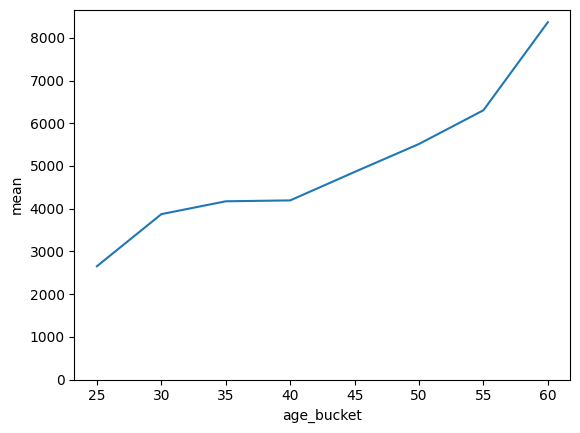

In [27]:
g = sns.lineplot(data=meps_agg, x="age_bucket", y="mean")
g.set(ylim=(0,None))
plt.savefig("img/expenditure_by_age.png")

The average cost is driven up by the few folks who do have high expenditures.  Median yearly expenditures are much lower than the average.

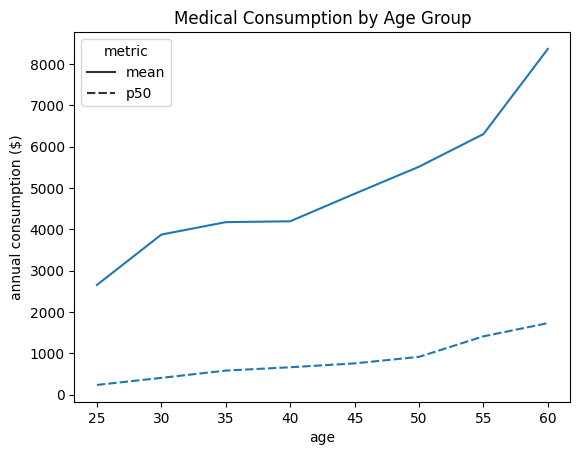

In [28]:
subs = pd.melt(meps_agg, id_vars=['age_bucket'], value_vars=['mean','p50'], var_name = 'metric', value_name='expenditure')
g = sns.lineplot(data=subs, x="age_bucket", y="expenditure", style = "metric")
g.set(ylabel="annual consumption ($)", xlabel="age", title="Medical Consumption by Age Group")
plt.savefig("img/median_expenditure.png")

In [30]:
meps_agg['mean2med'] = meps_agg['mean'] / meps_agg['p50']

In [31]:
meps_agg

,age_bucket,mean,p50,n,n_low,n_medium,n_high,mean_private,mean_self,pct_low,pct_medium,pct_high,pct_private,pct_self,mean2med
0,25,2653.218803,233.515102,916,639,215,62,2238.675679,413.110328,0.697598,0.234716,0.067686,0.843758,0.155702,11.362087
1,30,3872.324608,404.327075,975,622,261,92,3262.716026,608.212592,0.637949,0.267692,0.094359,0.842573,0.157067,9.577208
2,35,4173.046965,580.544490,1043,614,330,99,3504.456478,664.005968,0.588686,0.316395,0.094919,0.839784,0.159118,7.188160
3,40,4193.976514,661.085578,1060,593,361,106,3414.939088,776.063413,0.559434,0.340566,0.100000,0.814249,0.185042,6.344075
4,45,4859.747090,754.599728,947,517,338,92,4103.848230,753.773214,0.545935,0.356917,0.097149,0.844457,0.155105,6.440165
5,50,5515.000729,912.438639,1047,540,372,135,4754.199457,755.334909,0.515759,0.355301,0.128940,0.862049,0.136960,6.044243
6,55,6304.275973,1409.198775,1102,475,459,168,5433.112937,865.891994,0.431034,0.416515,0.152450,0.861814,0.137350,4.473660
7,60,8365.292726,1728.660407,1071,426,468,177,7342.834412,1014.090225,0.397759,0.436975,0.165266,0.877774,0.121226,4.839176


Even at older ages, there are still many folks with low healthcare expenditures.  However with age, there are more folks that develop meaningful health issues and so a larger fraction of the population has large expenditures.

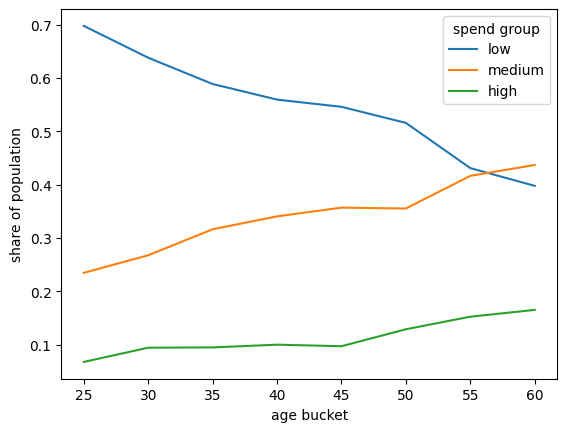

In [31]:
levels = ["low", "medium", "high"]
rename_dict = dict(zip(
    [f'pct_{x}' for x in levels]
    , levels
))
meps_copy = meps_agg.copy().rename(columns = rename_dict)
subs = pd.melt(meps_copy, id_vars=['age_bucket'], value_vars=[val for _,val in rename_dict.items()], var_name = 'spend group', value_name='share of population')
g = sns.lineplot(data=subs, x="age_bucket", y='share of population', hue = "spend group")
g.set(xlabel="age bucket")
plt.savefig("img/share_by_expenditure_group.png")

Look at this as a waterfall exercise

In [32]:
avg_10 = lambda x: np.mean(x)/10

In [33]:
wf = meps.groupby(['age_bucket2','spend_bkt']).agg(
    n = pd.NamedAgg('dupersid', 'count')
    , mean = pd.NamedAgg('med_exp', avg_10)
).reset_index()

In [34]:
wf_agg = meps.groupby(['age_bucket2']).agg(
    N = pd.NamedAgg('dupersid', 'count')
)

In [35]:
wf = wf.merge(wf_agg, how='left', on='age_bucket2')
wf['share'] = wf['n']/wf['N']

In [36]:
wf2 = wf.copy()
wf2['age_bucket2'] -= 10

In [37]:
wf_joined = wf.merge(wf2, how = 'inner', on=['age_bucket2','spend_bkt'], suffixes=('_t0','_t1'))

In [38]:
share_3 = wf_joined.loc[ wf_joined.spend_bkt == 'high', ['age_bucket2', 'share_t0', 'share_t1'] ].copy()
share_3.rename(columns={'share_t1':'share_t1_3', 'share_t0':'share_t0_3'}, inplace=True)

In [39]:
wf_joined = wf_joined.merge(share_3, how = 'left', on='age_bucket2')

In [40]:
wf_joined['share_special'] = wf_joined['share_t1_3']

In [41]:
mask = wf_joined['spend_bkt']!='high'
wf_joined.loc[mask,'share_special'] = \
    (wf_joined.loc[mask,'share_t0']/(1-wf_joined.loc[mask,'share_t0_3'])) * \
    (1-wf_joined.loc[mask,'share_t1_3'])

wf_joined['mean_special'] = wf_joined['mean_t1']
wf_joined.loc[mask, 'mean_special'] = wf_joined['mean_t0']

In [42]:
wf_joined['calc0'] = wf_joined['share_t0'] * wf_joined['mean_t0'] # base case
wf_joined['calc1'] = wf_joined['share_special'] * wf_joined['mean_t0'] # share of high
wf_joined['calc2'] = wf_joined['share_special'] * wf_joined['mean_special']  # mean for high
wf_joined['calc3'] = wf_joined['share_t1'] * wf_joined['mean_special'] # share of medium
wf_joined['calc4'] = wf_joined['share_t1'] * wf_joined['mean_t1'] # mean for medium

In [43]:
wf_final = wf_joined.groupby('age_bucket2').agg(
      calc0 = pd.NamedAgg('calc0', 'sum')
    , calc1 = pd.NamedAgg('calc1', 'sum')
    , calc2 = pd.NamedAgg('calc2', 'sum')
    , calc3 = pd.NamedAgg('calc3', 'sum')
    , calc4 = pd.NamedAgg('calc4', 'sum')
).reset_index()

In [44]:
wf_final['age_bucket2'] += 5
wf_final['delta'] = wf_final['calc4'] - wf_final['calc0']

for x in range(1,5):
    wf_final[f'pct_delta{x}'] = (wf_final[f'calc{str(x)}'] - wf_final[f'calc{str(x-1)}']) / wf_final['delta']
    wf_final[f'delta{x}'] = (wf_final[f'calc{str(x)}'] - wf_final[f'calc{str(x-1)}'])

In [45]:
subs.index = subs.index.astype('int64', copy=False)

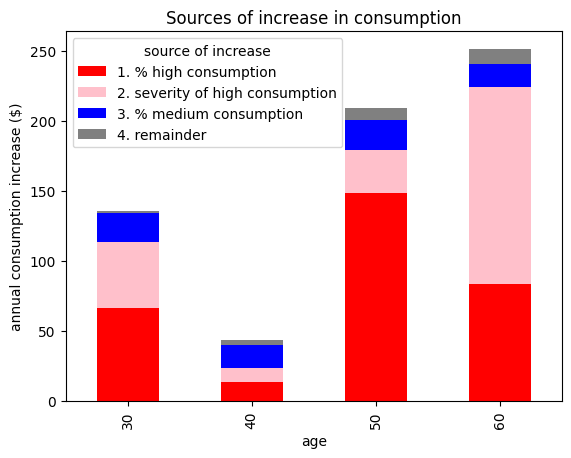

In [49]:
subs = wf_final[['age_bucket2',*[f'delta{x}' for x in range(1,5)]]].copy().set_index('age_bucket2')
subs.index = subs.index.astype('int64', copy=False)
rename_dict = dict(zip(
    [f'delta{x}' for x in range(1,5)]
    , ['1. % high consumption', '2. severity of high consumption', '3. % medium consumption', '4. remainder']
))
subs.rename(columns=rename_dict, inplace=True)

g = subs.plot(
    kind='bar', stacked=True, color=['red','pink','blue','gray'])
g.set(ylabel="annual consumption increase ($)"
     , xlabel="age"
     , title="Sources of increase in consumption")
g.legend_.set_title("source of increase")
plt.savefig('img/waterfall.png')

Most of these additional expenditures are covered by increasing payments from the insurance company, only a small fraction  of the incremental cost is passed on to the consumer.  The share of total expenditures covered by each payor is relatively consistent across age groups though.

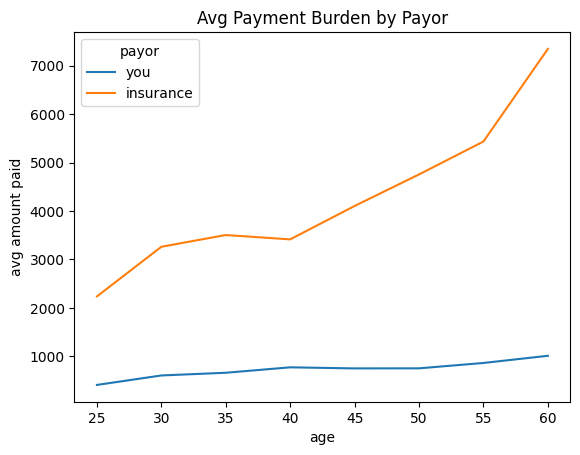

In [50]:
agg_cp = meps_agg.copy()
agg_cp.rename(columns={'mean_self':'you', 'mean_private':'insurance'}, inplace=True)
subs = pd.melt(agg_cp, id_vars=['age_bucket'], value_vars=['you','insurance'], var_name = 'payor', value_name='expenditure')
g = sns.lineplot(data=subs, x="age_bucket", y='expenditure', hue = "payor")
g.set(ylabel="avg amount paid"
     , xlabel = "age"
     , title = "Avg Payment Burden by Payor")
plt.savefig("img/payor_burden.png")

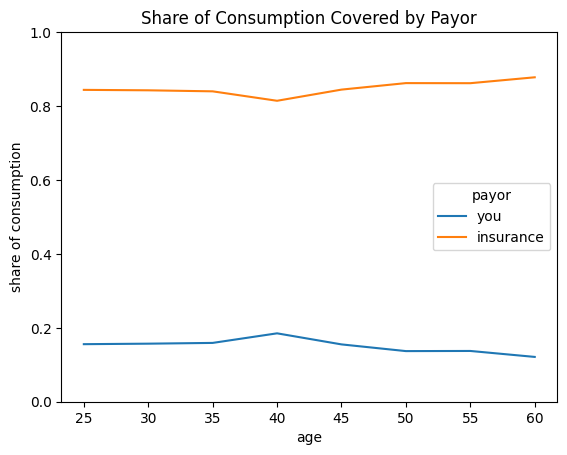

In [53]:
meps_agg_c = meps_agg.copy().rename(columns={'pct_self':'you','pct_private':'insurance'})

subs = pd.melt(meps_agg_c, id_vars=['age_bucket'], value_vars=['you','insurance'], var_name = 'payor', value_name='share of consumption')
g = sns.lineplot(data=subs, x="age_bucket", y='share of consumption', hue="payor")
g.set(xlabel="age"
     ,title="Share of Consumption Covered by Payor"
     ,ylim=(0,1))
plt.savefig("img/payor_share.png")

within each group though, the higher your expenditure, the larger share of your expenditures that the insurance company covers

In [56]:
meps_agg2 = meps.groupby(by=['age_bucket', 'spend_bkt'], as_index=False).agg(
    mean = pd.NamedAgg('med_exp', np.mean)
    , mean_private = pd.NamedAgg('med_exp_private', np.mean)
    , mean_self = pd.NamedAgg('med_exp_self', np.mean)
)

In [57]:
for tag in ['private','self']:
    meps_agg2[f'pct_{tag}'] = meps_agg2[f'mean_{tag}'] / meps_agg2['mean']

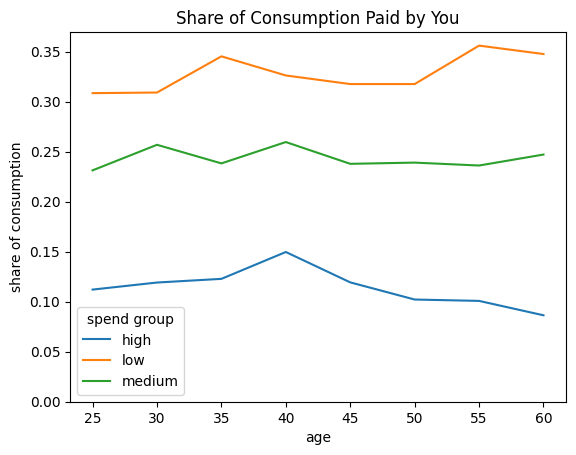

In [58]:
g = sns.lineplot(data=meps_agg2, x='age_bucket', y='pct_self', hue='spend_bkt')
g.set(ylim=(0,None)
     , ylabel = "share of consumption"
     , xlabel = "age"
     , title="Share of Consumption Paid by You")
g.legend_.set_title("spend group")
plt.savefig("img/pct_self_by_spend.png")

How do premiums increase with age

<AxesSubplot: xlabel='age', ylabel='p50_annual'>

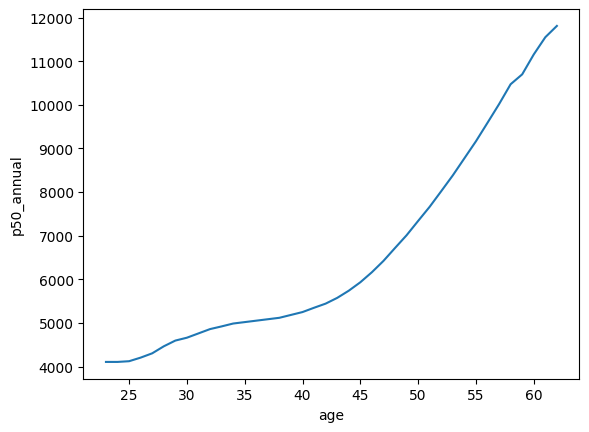

In [138]:
sns.lineplot(data=rates_agg, x="age", y="p50_annual")

How do the increasing payments from insurers compare to the annual amount paid by consumers in premiums.

In [61]:
rates_subs = rates_agg[['age','p50_annual']].copy()
rates_subs.rename(columns={'p50_annual':'amount'}, inplace=True)
rates_subs['metric'] = 'median annual premium'

meps_subs = meps_agg[['age_bucket','mean_private']].copy()

meps_subs['metric'] = 'avg insurance payment burden'

meps_subs.rename(columns={'mean_private':'amount', 'age_bucket':'age'}, inplace=True)

joint_rates = pd.concat([meps_subs, rates_subs])

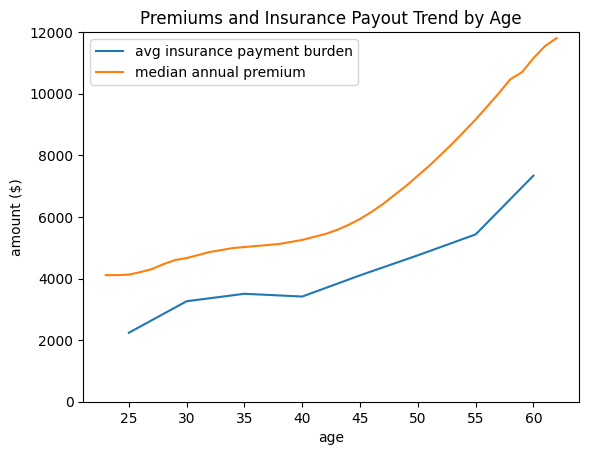

In [62]:
g = sns.lineplot(joint_rates, x = "age", y="amount", hue="metric")
g.set(ylim=(0,12000)
     , ylabel = "amount ($)"
     , title = "Premiums and Insurance Payout Trend by Age"
     )
g.legend_.set_title("")
plt.savefig("img/premiums_vs_carrier_burden.png")

# how will prices change

premiums will increase between 1 and 4%

In [315]:
# get yoy premium growth
rates_sub_t0 = rates_agg[['age', 'p50']].copy()

rates_sub_t1 = rates_agg[['age', 'p50']].copy()
rates_sub_t1['age'] -= 1
rates_sub_t1.rename(columns={'p50':'p50_t1'}, inplace=True)

rate_growth = rates_sub_t0.merge(rates_sub_t1, how="inner", on="age")
rate_growth['yoy_growth'] = rate_growth['p50_t1'] / rate_growth['p50'] - 1
rate_growth['metric'] = 'premiums'


In [318]:
rate_growth.head()

,age,p50,p50_t1,yoy_growth,metric
0,23,342.485,342.485,0.000000,premiums
1,24,342.485,343.845,0.003971,premiums
2,25,343.845,350.695,0.019922,premiums
3,26,350.695,358.915,0.023439,premiums
4,27,358.915,372.270,0.037209,premiums


In [326]:
meps_sub_t0 = meps_agg[['age_bucket', 'mean_self', 'mean']].copy()
meps_sub_t1 = meps_agg[['age_bucket', 'mean_self', 'mean']].copy()
meps_sub_t1['age_bucket'] -= 5

exp_growth = meps_sub_t0.merge(meps_sub_t1, how="inner", on="age_bucket", suffixes=("_t0","_t1"))
for x in ['mean_self', 'mean']:
    exp_growth[f'{x}_yoy'] = (exp_growth[f'{x}_t1'] / exp_growth[f'{x}_t0'])**(1/5) - 1
exp_growth['age_bucket'] += 2

exp_growth.rename(columns = {'age_bucket':'age', 'mean_yoy':'yoy_growth'}, inplace=True)
exp_growth['metric'] = 'expenses'


In [332]:
cols = ['age','yoy_growth', 'metric']
yoy_growth = pd.concat([rate_growth[cols], exp_growth[cols]])

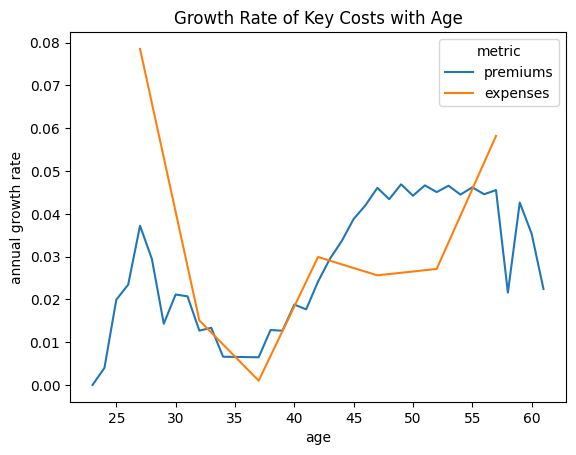

In [336]:
g = sns.lineplot(yoy_growth, x="age", y="yoy_growth", hue="metric")
g.set(
    ylabel = "annual growth rate"
    , title = "Growth Rate of Key Costs with Age"
)
plt.savefig("img/cost_growth.png")

Cost of medical services will increase too. Let's look at inflation.

In [341]:
inflation.reset_index(inplace=True)

In [342]:
inflation.DATE = pd.to_datetime(inflation.DATE)

In [343]:
inflation_t1 = inflation.copy()

inflation_t0 = inflation.copy()
inflation_t0.DATE = inflation_t0.DATE  + pd.offsets.DateOffset(years=1)

yoy_inflation = inflation_t1.merge(inflation_t0, how="inner", on="DATE", suffixes=("_t1", "_t0"))

In [344]:
for x in ["CPIMEDSL", "CPIAUCSL", "WPS411103"]:
    yoy_inflation[f"{x}_yoy"] = yoy_inflation[f"{x}_t1"] / yoy_inflation[f"{x}_t0"] - 1

In [346]:
rename_dict = {'CPIMEDSL_yoy':'medical inflation', 'CPIAUCSL_yoy': 'overall inflation'}
yoy_inflation.rename(columns=rename_dict, inplace=True)

infl_subs = pd.melt(yoy_inflation
                    , id_vars=['DATE']
#                     , value_vars=['CPIMEDSL_yoy','CPIAUCSL_yoy', 'WPS411103_yoy']
                    , value_vars=[val for _,val in rename_dict.items()]
                    , var_name = 'index'
                    , value_name='inflation rate'
                   )

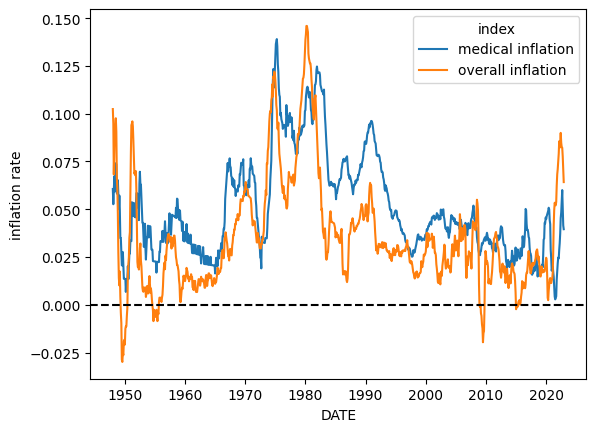

In [347]:
g = sns.lineplot(infl_subs, x="DATE", y="inflation rate", hue="index")
g.axhline(0, color="black", linestyle="--")
plt.savefig("img/inflation_trend.png")